# Deploy Single Shot Multibox Detector(SSD) model

**Author**: *Yao Wang*, *Leyuan Wang*

This article is an introductory tutorial to deploy SSD models with TVM.
We will use GluonCV pre-trained SSD model and convert it to Relay IR

In [1]:
!pip3 install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple/ --user psutil xgboost==1.0.2 tornado
!pip3 install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple/ --user antlr4-python3-runtime
!pip3 install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple/ --user gluoncv

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple/
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import sys
sys.path.insert(0, "tvm_upstream/python")
sys.path.insert(0, "tvm_upstream/topi/python")

import tvm
from tvm import te

from matplotlib import pyplot as plt
from tvm.relay.testing.config import ctx_list
from tvm import relay
from tvm.contrib import graph_runtime
from tvm.contrib.download import download_testdata
from gluoncv import model_zoo, data, utils

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [31]:
from tvm.autotvm.measure.measure_methods import set_cuda_target_arch
set_cuda_target_arch('sm_37')

## Preliminary and Set parameters

We support compiling SSD on both CPUs and GPUs now.

To get best inference performance on CPU, change
target argument according to your device and
follow the `tune_relay_x86` to tune x86 CPU and
`tune_relay_arm` for arm CPU.

To get best inference performance on Intel graphics,
change target argument to :code:`opencl -device=intel_graphics`.
But when using Intel graphics on Mac, target needs to
be set to `opencl` only for the reason that Intel subgroup
extension is not supported on Mac.

To get best inference performance on CUDA-based GPUs,
change the target argument to :code:`cuda`; and for
OPENCL-based GPUs, change target argument to
`opencl` followed by device argument according
to your device.

In [3]:
supported_model = [
    'ssd_512_resnet50_v1_voc',
    'ssd_512_resnet50_v1_coco',
    'ssd_512_resnet101_v2_voc',
    'ssd_512_mobilenet1.0_voc',
    'ssd_512_mobilenet1.0_coco',
    'ssd_300_vgg16_atrous_voc'
    'ssd_512_vgg16_atrous_coco',
]

model_name = supported_model[0]
dshape = (1, 3, 512, 512)
target_list = ctx_list()

Download and pre-process demo image

In [7]:
!mkdir -p ~/.tvm_test_data/data/
!cp street_small.jpg ~/.tvm_test_data/data/
im_fname = download_testdata('https://github.com/dmlc/web-data/blob/master/' +
                             'gluoncv/detection/street_small.jpg?raw=true',
                             'street_small.jpg', module='data')

File /home/ec2-user/.tvm_test_data/data/street_small.jpg exists, skip.


In [8]:
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)

Convert and compile model for CPU.

In [9]:
block = model_zoo.get_model(model_name, pretrained=True)

def build(target):
    mod, params = relay.frontend.from_mxnet(block, {"data": dshape})
    with relay.build_config(opt_level=3):
        graph, lib, params = relay.build(mod, target, params=params)
    return graph, lib, params

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


100%|██████████| 132723/132723 [00:48<00:00, 2759.42KB/s]


## Create TVM runtime and do inference

In [14]:
import time
def run(graph, lib, params, ctx):
    # Build TVM runtime
    m = graph_runtime.create(graph, lib, ctx)
    tvm_input = tvm.nd.array(x.asnumpy(), ctx=ctx)
    m.set_input('data', tvm_input)
    m.set_input(**params)
    
    tic = time.time()
    # execute
    m.run()
    # get outputs
    class_IDs, scores, bounding_boxs = m.get_output(0).asnumpy()[0], m.get_output(1).asnumpy()[0], m.get_output(2).asnumpy()[0]
    toc = time.time()

    tic = time.time()
    # execute
    m.run()
    # get outputs
    class_IDs, scores, bounding_boxs = m.get_output(0).asnumpy()[0], m.get_output(1).asnumpy()[0], m.get_output(2).asnumpy()[0]
    toc = time.time()
    print("done! elapsed: {:.2f} ms.".format((toc-tic)*1000.0))

    return class_IDs, scores, bounding_boxs

for target, ctx in target_list:
    graph, lib, params = build(target)
    print("running on {}".format(target))
    class_IDs, scores, bounding_boxs = run(graph, lib, params, ctx)

running on cuda
done! elapsed: 5460.62 ms.
running on llvm
done! elapsed: 1994.55 ms.


## Display result

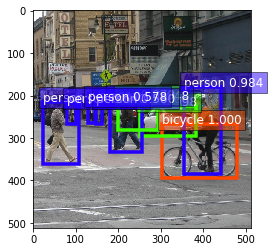

In [15]:
ax = utils.viz.plot_bbox(img, bounding_boxs, scores,
                         class_IDs, class_names=block.classes)
plt.show()

## Begin Tuning

In [32]:
import os
from tvm import autotvm
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

#### DEVICE CONFIG ####
target = tvm.target.cuda(model="k80")
from tvm.autotvm.measure.measure_methods import set_cuda_target_arch
set_cuda_target_arch('sm_37')

# You can skip the implementation of this function for this tutorial.
def tune_tasks(tasks,
               measure_option,
               tuner='xgb',
               n_trial=1000,
               early_stopping=None,
               log_filename='tuning.log',
               use_transfer_learning=True):
    # create tmp log file
    tmp_log_file = log_filename + ".tmp"
    if os.path.exists(tmp_log_file):
        os.remove(tmp_log_file)

    for i, tsk in enumerate(reversed(tasks)):
        prefix = "[Task %2d/%2d] " %(i+1, len(tasks))

        # create tuner
        if tuner == 'xgb' or tuner == 'xgb-rank':
            tuner_obj = XGBTuner(tsk, loss_type='rank')
        elif tuner == 'ga':
            tuner_obj = GATuner(tsk, pop_size=100)
        elif tuner == 'random':
            tuner_obj = RandomTuner(tsk)
        elif tuner == 'gridsearch':
            tuner_obj = GridSearchTuner(tsk)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        if use_transfer_learning:
            if os.path.isfile(tmp_log_file):
                tuner_obj.load_history(autotvm.record.load_from_file(tmp_log_file))

        # do tuning
        tsk_trial = min(n_trial, len(tsk.config_space))
        tuner_obj.tune(n_trial=tsk_trial,
                       early_stopping=early_stopping,
                       measure_option=measure_option,
                       callbacks=[
                           autotvm.callback.progress_bar(tsk_trial, prefix=prefix),
                           autotvm.callback.log_to_file(tmp_log_file)
                       ])

    # pick best records to a cache file
    autotvm.record.pick_best(tmp_log_file, log_filename)
    os.remove(tmp_log_file)

In [33]:
# Finally, we launch tuning jobs and evaluate the end-to-end performance.
def tune_and_evaluate(tuning_opt):
    # extract workloads from relay program
    print("Extract tasks...")
    # mod, params, input_shape, out_shape = get_network(network, batch_size=1)
    mod, params = relay.frontend.from_mxnet(block, {"data": dshape})
    input_shape = dshape
    tasks = autotvm.task.extract_from_program(mod["main"], target=target,
                                              params=params,
                                              ops=(relay.op.get("nn.conv2d"),))

    # run tuning tasks
    print("Tuning...")
    tune_tasks(tasks, **tuning_opt)

    # compile kernels with history best records
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with relay.build_config(opt_level=3):
            graph, lib, params = relay.build_module.build(
                mod, target=target, params=params)

        # export library
        tmp = tempdir()
        filename = "net.tar"
        lib.export_library(tmp.relpath(filename))

        # load parameters
        ctx = tvm.context(str(target), 0)
        module = runtime.create(graph, lib, ctx)
        data_tvm = tvm.nd.array((np.random.uniform(size=input_shape)).astype(dtype))
        module.set_input('data', data_tvm)
        module.set_input(**params)

        # evaluate
        print("Evaluate inference time cost...")
        ftimer = module.module.time_evaluator("run", ctx, number=1, repeat=600)
        prof_res = np.array(ftimer().results) * 1000  # convert to millisecond
        print("Mean inference time (std dev): %.2f ms (%.2f ms)" %
              (np.mean(prof_res), np.std(prof_res)))

In [ ]:
#### TUNING OPTION ####
network = model_name
log_file = "%s.log" % network
dtype = 'float32'

tuning_option = {
    'log_filename': log_file,

    'tuner': 'xgb',
    'n_trial': 200,
    'early_stopping': 60,

    'measure_option': autotvm.measure_option(
        builder=autotvm.LocalBuilder(timeout=10),
        #runner=autotvm.LocalRunner(number=20, repeat=3, timeout=4, min_repeat_ms=150),
        runner=autotvm.RPCRunner(
            '1080ti',  # change the device key to your key
            '0.0.0.0', 9190,
            number=20, repeat=3, timeout=4, min_repeat_ms=150)
    ),
}

tune_and_evaluate(tuning_option)

Extract tasks...
 Done.
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
ANTLR runtime and generated code versions disagree: 4.8!=4.7.2
Tuning...
[Task  1/55]  Current/Best:    1.94/   2.49 GFLOPS | Progress: (108/200) | 237.85 s